# Классификация с помощью kNN. Кластеризация K-means

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [3]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [4]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

In [6]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [7]:
def knn(x_train, y_train, x_test, k, weight_func):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        # В зависимости от расстояния до соседних точек у нас будет разный вес - т.е. класс "голосует"
        # для соответствующего ему расстояния прибавляя 1 умноженную на вес
        for d in sorted(test_distances)[0:k]:
            w=weight_func(d[0])
            classes[d[1]] += 1*w
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [8]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [9]:
def get_graph(X_train, y_train, k, weight_func):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k,weight_func)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

1. Возьмем коэффициент веса в зависимости от расстояния $d$ по формуле:
     
 $w(d) = q^{d}$,   $q \in (0,1)$;
 q=0.5
 
2. Второй случай возьмем коэффициент веса в зависимости от расстояния $d$ по другой формуле:

 $w(d) = \frac{1}{(d+a)^{b}}$,
 a=0.1, b=0.5

In [28]:
def weight1(distance,q=0.5):
    return q**distance

In [42]:
def weight2(distance,a=0.1,b=0.9):
    return 1/((distance+a)**b)

In [38]:
k = 5

y_pred = knn(X_train, y_train, X_test, k,weight1)

print(f'Точность алгоритма при weigt1 k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при weigt1 k = 5: 0.867


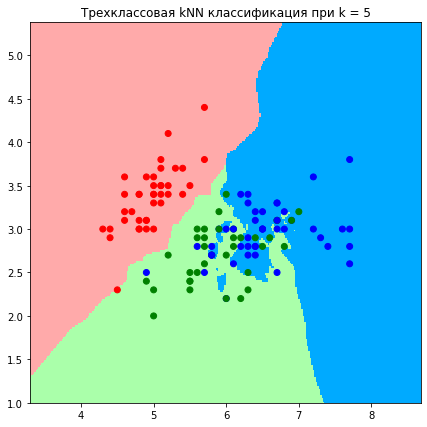

In [39]:
cmap = ListedColormap(['red', 'green', 'blue'])
get_graph(X_train, y_train, k, weight1)

In [43]:
k = 5

y_pred = knn(X_train, y_train, X_test, k,weight2)

print(f'Точность алгоритма при weigt2 k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при weigt2 k = 5: 0.833


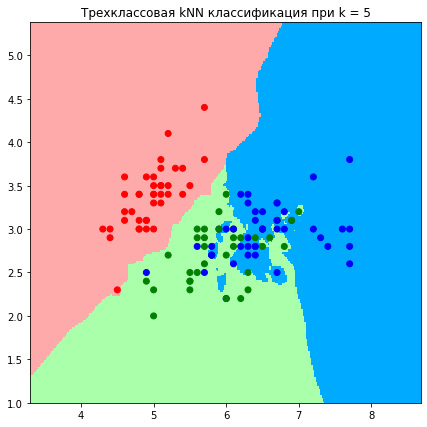

In [44]:
cmap = ListedColormap(['red', 'green', 'blue'])
get_graph(X_train, y_train, k,weight2)

2*. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить 
график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [10]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)

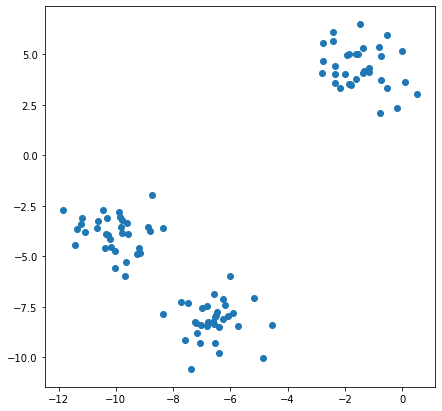

In [11]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [12]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [13]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

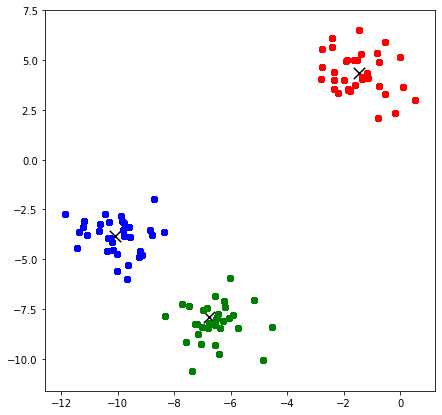

In [14]:
# определим максимальное количество итераций
max_iterations = 10

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

In [18]:
def mean_square_intracluster_dist(centroids, classes):
    metric = 0
    for i, centroid in enumerate(centroids):
        k = len(classes[i])
        metric += sum([np.square(e_metrics(x, centroid)) for x in classes[i]]) / k
    return metric

In [36]:
def quality(centroids, clusters):
    sum_total=0    
    for k in range(len(centroids)):
        distance = 0
        for x in clusters[k]:           
            distance += np.square(e_metrics(x,centroids[k]))            
        
        sum_total += distance/len(clusters[k])      
    return sum_total

In [37]:
clusters_arr=[1,2,3,4,5,6,7,8,9,10]
quality_arr=[]
for k in clusters_arr:
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    quality_arr.append(quality(centroids, clusters))
print(quality_arr)


[41.181537777044724, 10.8818490946027, 6.054744609629033, 5.407238011751332, 5.135706103163564, 5.786977171344443, 5.647205847915786, 5.859161222488832, 6.188134837104741, 6.35591857885726]


Text(0, 0.5, 'quality')

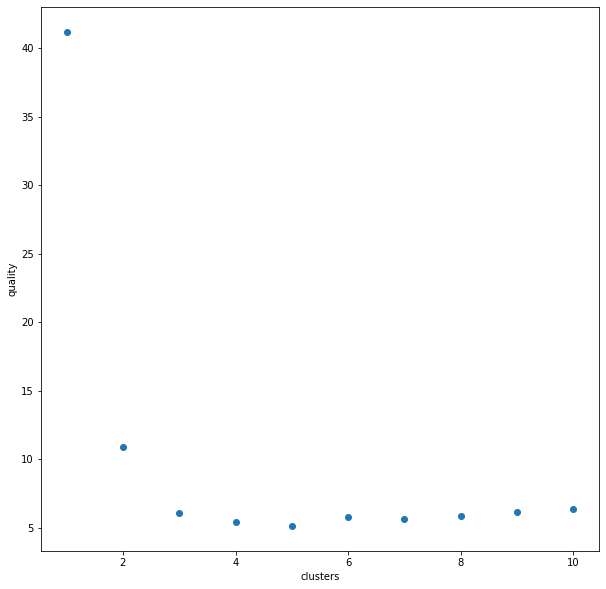

In [38]:
plt.figure(figsize=(10,10))
plt.scatter(clusters_arr, quality_arr)
plt.xlabel('clusters')
plt.ylabel('quality')

Вывод - чем больше кластеров, тем меньше среднее квадратичное внутриклассовое расстояние